# Make visualizations for poster

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch, Circle
import os
import json
from dual_alm_rnn_models import TwoHemiRNNTanh_single_readout
from dual_alm_rnn_exp import DualALMRNNExp
import sys
import argparse, os, math, pickle, json

plt.rcParams['pdf.fonttype'] = '42' 

In [70]:
traces = np.load('dual_alm_rnn_data/train/onehot_sensory_inputs_simple.npy')
labels = np.load('dual_alm_rnn_data/train/onehot_trial_type_labels_simple.npy')
exp=DualALMRNNExp()

In [71]:
traces.shape, labels.shape, labels[:3]

((1000, 125, 2), (1000,), array([1, 1, 0]))

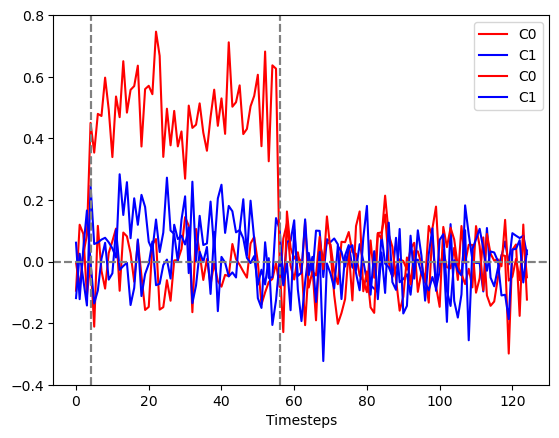

In [42]:
plt.plot(traces[1, :, 0]*0.2+np.random.randn(125) * 0.1, c='red', label='C0')
plt.plot(traces[1, :, 1]*0.2+np.random.randn(125) * 0.1, c='blue', label='C1')
plt.axhline(0, ls='--', color='grey')
plt.axvline(exp.sample_begin, ls='--', color='grey')
plt.axvline(exp.delay_begin, ls='--', color='grey')
plt.xlabel('Timesteps')
plt.ylim(-0.4,0.8)
plt.legend()
plt.savefig('figs/right_sens_1.pdf')


plt.plot(traces[2, :, 0]+np.random.randn(125) * 0.1, c='red', label='C0')
plt.plot(traces[2, :, 1]+np.random.randn(125) * 0.1, c='blue', label='C1')
plt.axhline(0, ls='--', color='grey')
plt.axvline(exp.sample_begin, ls='--', color='grey')
plt.axvline(exp.delay_begin, ls='--', color='grey')
plt.xlabel('Timesteps')
plt.ylim(-0.4,0.8)
plt.legend()
plt.savefig('figs/lef_sens_5.pdf')




Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_single_readout_fixed_input/n_neurons_4_random_seed_0/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.20/model_epoch_11.pth


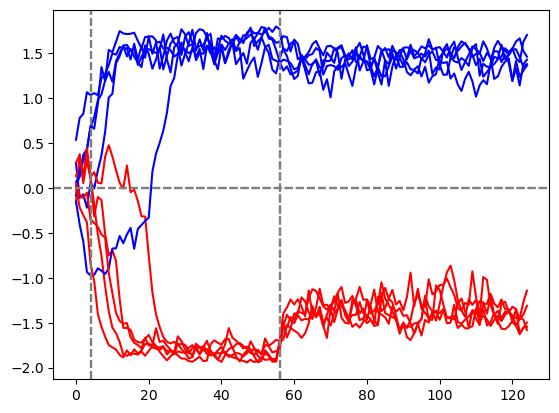

In [157]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)

model = getattr(sys.modules[__name__], configs['model_type'])(configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(configs['train_type'])

checkpoint_file = 'model_epoch_11.pth'
checkpoint_path = os.path.join(configs['models_dir'], configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()


train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_simple.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels_simple.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input.shape

l_trial_input_all = l_trial_input
r_trial_input_all = r_trial_input

for i in range(5):
    l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
    r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)
    
    hs, zs = model(l_trial_input)
    hs_r, zs_r = model(r_trial_input)

 # Add zs as a fifth subplot, centered in the third row, same aspect ratio as others
    plt.plot(zs_r[0, :, 0].detach().cpu().numpy(), color='blue', alpha=1.0)
    plt.plot(zs[0, :, 0].detach().cpu().numpy(), color='red', alpha=1.0)
    plt.axhline(0, ls='--', color='grey')
    plt.axvline(exp.sample_begin, ls='--', color='grey')
    plt.axvline(exp.delay_begin, ls='--', color='grey')
    # plt.savefig('figs/readout_traj.pdf')




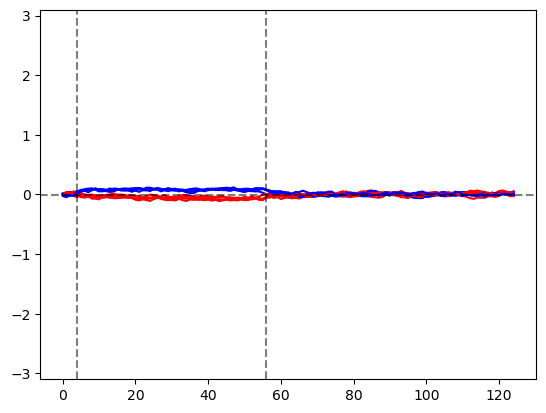

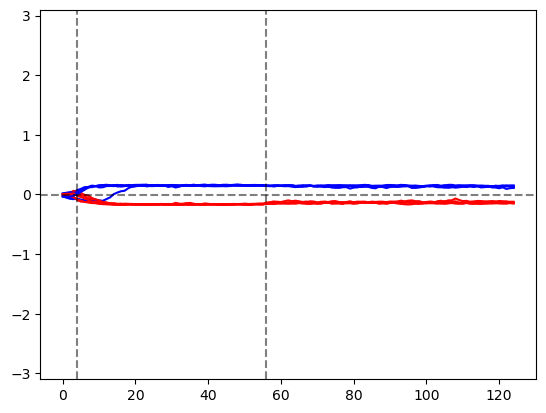

In [159]:
# plot as overlay over all trials


import matplotlib.gridspec as gridspec


hs, zs = model(l_trial_input_all)
hs_r, zs_r = model(r_trial_input_all)



f=plt.figure()

for trial_idx in [101, 102,103,107,105]:
    pre_left_readout = np.sum(hs[trial_idx, :, :2].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    pre_right_readout = np.sum(hs_r[trial_idx, :, :2].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    plt.plot(pre_left_readout, color='red', alpha=1)
    plt.plot(pre_right_readout, color='blue', alpha=1)
plt.axhline(bias, color='black', alpha=0.5, ls='--')
plt.axvline(exp.sample_begin, color='black', alpha=0.5, ls='--')
plt.axvline(exp.delay_begin, color='black', alpha=0.5, ls='--')
plt.ylim(-3.1,3.1)
# plt.savefig('figs/pre_readout_left_learned.pdf')

plt.show()

f=plt.figure()

for trial_idx in [101, 102,103,104,105]:
    pre_left_readout = np.sum(hs[trial_idx, :, 2:].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    pre_right_readout = np.sum(hs_r[trial_idx, :, 2:].detach().cpu().numpy() * readout_weights.flatten()[:2], axis=1)
    plt.plot(pre_left_readout, color='red', alpha=1)
    plt.plot(pre_right_readout, color='blue', alpha=1)
plt.axhline(bias, color='black', alpha=0.5, ls='--')
plt.axvline(exp.sample_begin, color='black', alpha=0.5, ls='--')
plt.axvline(exp.delay_begin, color='black', alpha=0.5, ls='--')
plt.ylim(-3.1,3.1)
# plt.savefig('figs/pre_readout_right_learned.pdf')
plt.show()


[0.89371824, 0.7517734, 0.61844724, 0.5482109, 0.5359054, 0.518846, 0.5229925, 0.37961188, 0.37457153, 0.27524334, 0.23808889, 0.20363088, 0.1743532]


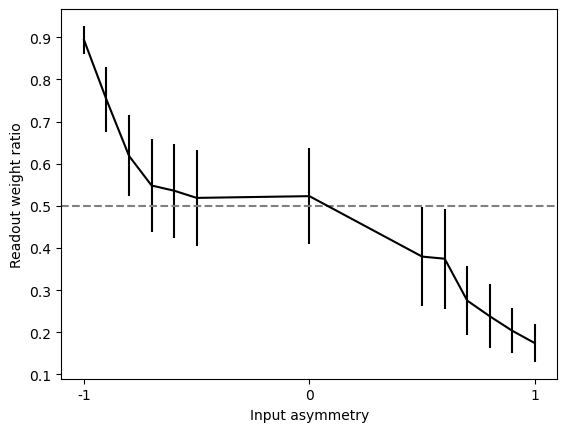

In [44]:

input_asym = [(1,0), (1,0.1), (1,0.2), (1,0.3), (1,0.4), (1,0.5), (1,1), (0.5,1), (0.4,1), (0.3,1), (0.2,1), (0.1,1), (0,1)] # Sane as BK

# Initialize experiment
exp = DualALMRNNExp()
weights_dict = np.load('small_rnn_corrupted_weights_0p5noise_epoch11_40epochs.npy', allow_pickle=True)
weights_dict = np.load('small_rnn_sherlock_weights_corruption_0p7noise_epoch11.npy', allow_pickle=True)
weights_dict = np.load('small_rnn_sherlock_weights_fixed_input.npy', allow_pickle=True)
# weights_dict = np.load('small_rnn_corrupted_weights_fixed_input_0p5noise_epoch15_40epochs.npy', allow_pickle=True)

all_weights = []
control_std = []
for asym in input_asym:


    # all_weights += [np.mean([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, exp.n_neurons//2:])) for i in range(10)])]
    # control_std += [np.std([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, exp.n_neurons//2:])) for i in range(10)]) / np.sqrt(10)]


    all_weights += [np.mean([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, :])) for i in range(10)])]
    control_std += [np.std([np.sum(np.abs(weights_dict.item()[asym][i][0, :exp.n_neurons//2])) / np.sum(np.abs(weights_dict.item()[asym][i][0, :])) for i in range(10)]) / np.sqrt(10)]

    # all_weights = [weights_dict.item()[asym][i][0, :exp.n_neurons//2] / weights_dict.item()[asym][i][0, :] for i in range(10)]
    # for seed in range(1,10):
    #     exp = DualALMRNNExp()
    #     exp.configs['xs_left_alm_amp'] = asym[0]
    #     exp.configs['xs_right_alm_amp'] = asym[1]

    #     # For each asymmetry, print the logs path for the config
    #     exp.init_sub_path('train_type_modular')
    #     logs_path = os.path.join(exp.configs['logs_dir'], exp.configs['model_type'], exp.sub_path)
    #     # print(f"Input asymmetry {asym}: logs path = {logs_path}")

    #     weights = np.load(os.path.join(logs_path, 'readout_weights_epoch_final.npy'))
    #     ratio = np.sum(np.abs(weights)[0, :exp.n_neurons//2]) / np.sum(np.abs(weights)[0, :])
    #     # all_weights.append(weights)
    
    # weights_dict[asym] = all_weights
# import pdb; pdb.set_trace()
print(all_weights)
# xlabels=[-1, -0.8, -0.6, -0.2, 0, 0.2, 0.6, 0.8, 1]
xlabels=[-1, -0.9, -0.8, -0.7, -0.6, -0.5, 0, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# plt.plot(xlabels, all_weights, ls='--', marker='o')
plt.errorbar(xlabels, all_weights, yerr=control_std, label='Control', color='black', ls='-')
# plt.errorbar(xlabels, right_pert_acc, yerr=right_pert_std, label='Right pert', color='darkgrey')
# plt.errorbar(xlabels, left_pert_acc, yerr=left_pert_std, label='Left pert', color='lightgrey')
plt.ylabel('Readout weight ratio')
plt.xlabel('Input asymmetry')
# plt.ylim(0, 1)
plt.xticks([-1,0,1],[-1,0,1])
# plt.legend()
plt.axhline(0.5, ls='--', color='grey')
plt.savefig('figs/all_competition_fixed_input.pdf')
# plt.savefig('figs/all_competition_tenseeds_corruption_0p7noise_epoch11.pdf')
plt.show()
# breakpoint()


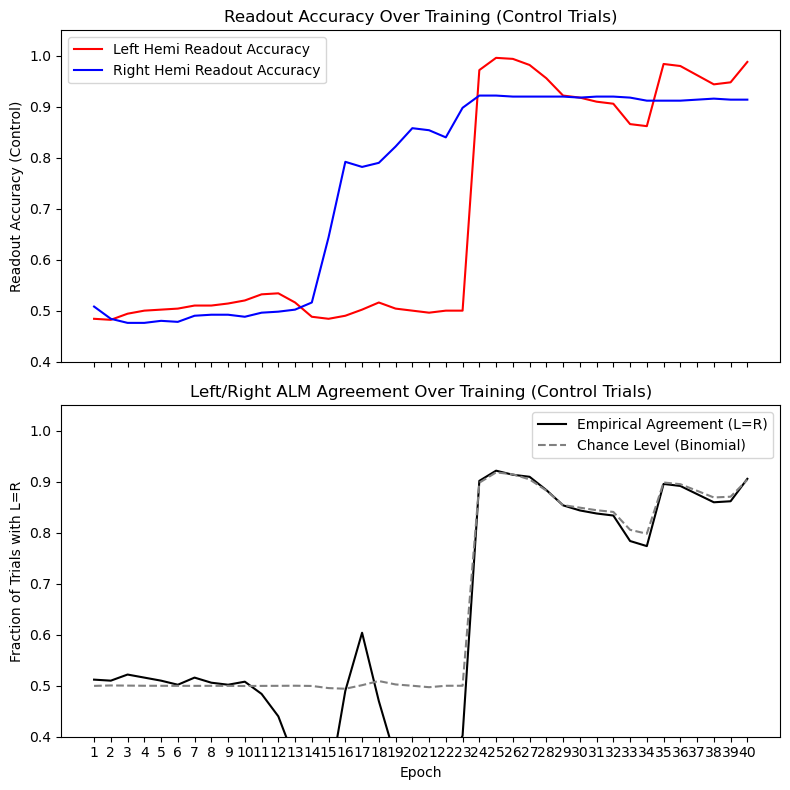

In [48]:
exp = DualALMRNNExp()

# if 'train_type_modular_corruption' in exp.configs['train_type']:
#     results_dict = np.load(
#         'dual_alm_rnn_logs/{}/train_type_modular_corruption/onehot_cor_type_{}_epoch_{}_noise_{:.2f}/n_neurons_4_random_seed_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
#             exp.configs['model_type'],
#             exp.configs['corruption_type'],
#             exp.configs['corruption_start_epoch'],
#             float(exp.configs['corruption_noise']),
#             exp.configs['random_seed'],
#             float(exp.configs['xs_left_alm_amp']),
#             float(exp.configs['xs_right_alm_amp'])
#         ),
#         allow_pickle=True
#     )
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     results_dict = np.load(
#         'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/unfix_epoch_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
#             exp.configs['model_type'],
#             exp.configs['train_type'],
#             exp.configs['random_seed'],
#             exp.configs['unfix_epoch'],
#             float(exp.configs['xs_left_alm_amp']),
#             float(exp.configs['xs_right_alm_amp'])),
#             allow_pickle=True
#     )
# else:
for seed in range(1,10):
    results_dict = np.load(
        'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/all_val_results_dict.npy'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp'])
        ),
        allow_pickle=True
    )
    epochs = np.arange(1, len(results_dict) + 1)
    readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
    readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])

    n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
    n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
    agreement_frac = n_trials_agreed / n_trials

    # Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
    chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

    corruption_start_epoch = exp.configs['corruption_start_epoch']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top subplot: Readout accuracies
ax1.plot(epochs, readout_acc_left, color='r', label='Left Hemi Readout Accuracy')
ax1.plot(epochs, readout_acc_right, color='b', label='Right Hemi Readout Accuracy')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax1.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax1.set_ylabel('Readout Accuracy (Control)')
ax1.set_title('Readout Accuracy Over Training (Control Trials)')
ax1.set_xticks(epochs)
ax1.set_ylim(0.4, 1.05)
ax1.legend()

# Bottom subplot: Agreement
ax2.plot(epochs, agreement_frac, color='k', label='Empirical Agreement (L=R)')
ax2.plot(epochs, chance_agree, color='gray', linestyle='--', label='Chance Level (Binomial)')
if exp.configs['train_type'] == 'train_type_modular_corruption':
    ax2.axvline(corruption_start_epoch, color='r', linestyle=':', linewidth=2, label='Corruption Start (Epoch {})'.format(corruption_start_epoch))
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Fraction of Trials with L=R')
ax2.set_title('Left/Right ALM Agreement Over Training (Control Trials)')
ax2.set_xticks(epochs)
ax2.set_ylim(0.4, 1.05)
ax2.legend()

plt.tight_layout()
plt.show()
# if exp.configs['train_type'] == 'train_type_modular_corruption':
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_epoch_{}_noise_{}0_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                                             exp.configs['corruption_start_epoch'], 
#                                                                                                             exp.configs['corruption_noise'], 
#                                                                                                             exp.configs['corruption_type']))
# elif 'asymmetric_fix' in exp.configs['train_type']:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_unfix_epoch_{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['unfix_epoch'],
#                                                                                             exp.configs['train_type']))
# else:
#     plt.savefig('figs/LR_readoutacc_and_agreement_learning_{}_L{}_R{}_type_{}.pdf'.format(exp.configs['train_type'], 
#                                                                                             exp.configs['xs_left_alm_amp'], 
#                                                                                             exp.configs['xs_right_alm_amp'], 
#                                                                                             exp.configs['train_type']))
# plt.show()

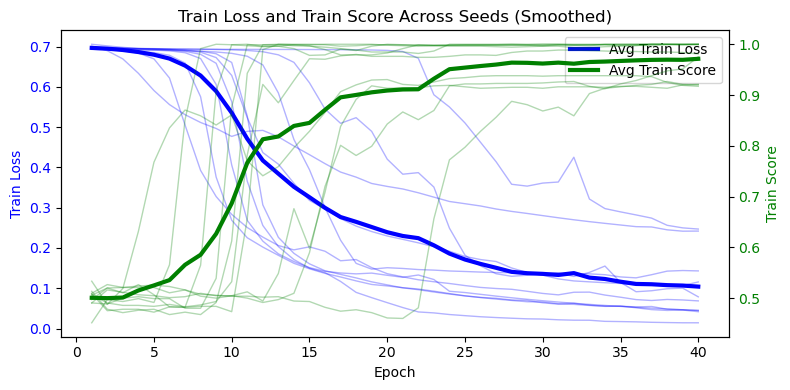

In [63]:
# Plot the training score and training loss for all seeds

# fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# for seed in range(10):
#     exp = DualALMRNNExp()
    
#     path = 'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/'.format(
#             exp.configs['model_type'],
#             exp.configs['train_type'],
#             seed,
#             float(exp.configs['xs_left_alm_amp']),
#             float(exp.configs['xs_right_alm_amp']))
    

#     train_losses = np.load(os.path.join(path, 'all_epoch_train_losses.npy'), allow_pickle=True)
#     train_scores = np.load(os.path.join(path, 'all_epoch_train_scores.npy'), allow_pickle=True)

#     val_losses = np.load(os.path.join(path, 'all_epoch_val_losses.npy'), allow_pickle=True)
#     val_scores = np.load(os.path.join(path, 'all_epoch_val_scores.npy'), allow_pickle=True)


#     epochs = np.arange(1, len(train_losses) + 1)


#     # Plot losses
import matplotlib.pyplot as plt
import numpy as np

# Collect all train losses and scores for all seeds
import matplotlib.pyplot as plt
import numpy as np

def smooth(x, window_size):
    """Simple moving average smoothing."""
    if window_size < 2:
        return x
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'same')

window_size = 14  # Smoothing window

all_train_losses = []
all_train_scores = []
for seed in range(10):
    exp = DualALMRNNExp()
    path = 'dual_alm_rnn_logs/{}/{}/n_neurons_4_random_seed_{}/n_epochs_40_n_epochs_across_hemi_0/lr_3.0e-03_bs_75/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_{:.2f}_right_alm_amp_{:.2f}/init_cross_hemi_rel_factor_0.20/'.format(
            exp.configs['model_type'],
            exp.configs['train_type'],
            seed,
            float(exp.configs['xs_left_alm_amp']),
            float(exp.configs['xs_right_alm_amp']))
    train_losses = np.load(os.path.join(path, 'all_epoch_train_losses.npy'), allow_pickle=True)
    train_scores = np.load(os.path.join(path, 'all_epoch_train_scores.npy'), allow_pickle=True)
    all_train_losses.append(train_losses)
    all_train_scores.append(train_scores)

# Convert to arrays for easier averaging
all_train_losses = np.array(all_train_losses)
all_train_scores = np.array(all_train_scores)
epochs = np.arange(1, all_train_losses.shape[1] + 1)

# Smooth all measures
# Instead of smoothing, average every 14 points (epochs) in the array
def average_every_n(x, n):
    # Truncate to a multiple of n
    length = (len(x) // n) * n
    x = x[:length]
    return x.reshape(-1, n).mean(axis=1)

all_train_losses_avg = np.array([average_every_n(x, window_size) for x in all_train_losses])
all_train_scores_avg = np.array([average_every_n(x, window_size) for x in all_train_scores])
epochs_avg = np.arange(1, all_train_losses_avg.shape[1] + 1)

# For downstream code, replace *_smooth with *_avg
all_train_losses_smooth = all_train_losses_avg
all_train_scores_smooth = all_train_scores_avg
epochs = epochs_avg
mean_train_loss = np.mean(all_train_losses_smooth, axis=0)
mean_train_score = np.mean(all_train_scores_smooth, axis=0)

fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot individual seed lines (thin, smoothed)
for i in range(all_train_losses_smooth.shape[0]):
    ax1.plot(epochs, all_train_losses_smooth[i], color='blue', alpha=0.3, linewidth=1)
ax1.set_ylabel('Train Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot average train loss (thick, smoothed)
ax1.plot(epochs, mean_train_loss, color='blue', linewidth=3, label='Avg Train Loss')

# Create second y-axis for train score
ax2 = ax1.twinx()
for i in range(all_train_scores_smooth.shape[0]):
    ax2.plot(epochs, all_train_scores_smooth[i], color='green', alpha=0.3, linewidth=1)
ax2.set_ylabel('Train Score', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Plot average train score (thick, smoothed)
ax2.plot(epochs, mean_train_score, color='green', linewidth=3, label='Avg Train Score')

ax1.set_xlabel('Epoch')
ax1.set_title('Train Loss and Train Score Across Seeds (Smoothed)')

# Set x-ticks so that every 14 epochs is labeled as 1, 2, 3 (for 40 epochs, so 14, 28, 40)
# xtick_locs = np.arange(14, 41, 14)
# xtick_labels = [str(i+1) for i in range(len(xtick_locs))]
# ax1.set_xticks(xtick_locs)
# ax1.set_xticklabels(xtick_labels)
ax1.set_xlabel('Epoch')
# Add legends for the thick lines only
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.savefig('figs/train_loss_and_score_across_seeds.pdf')
plt.show()


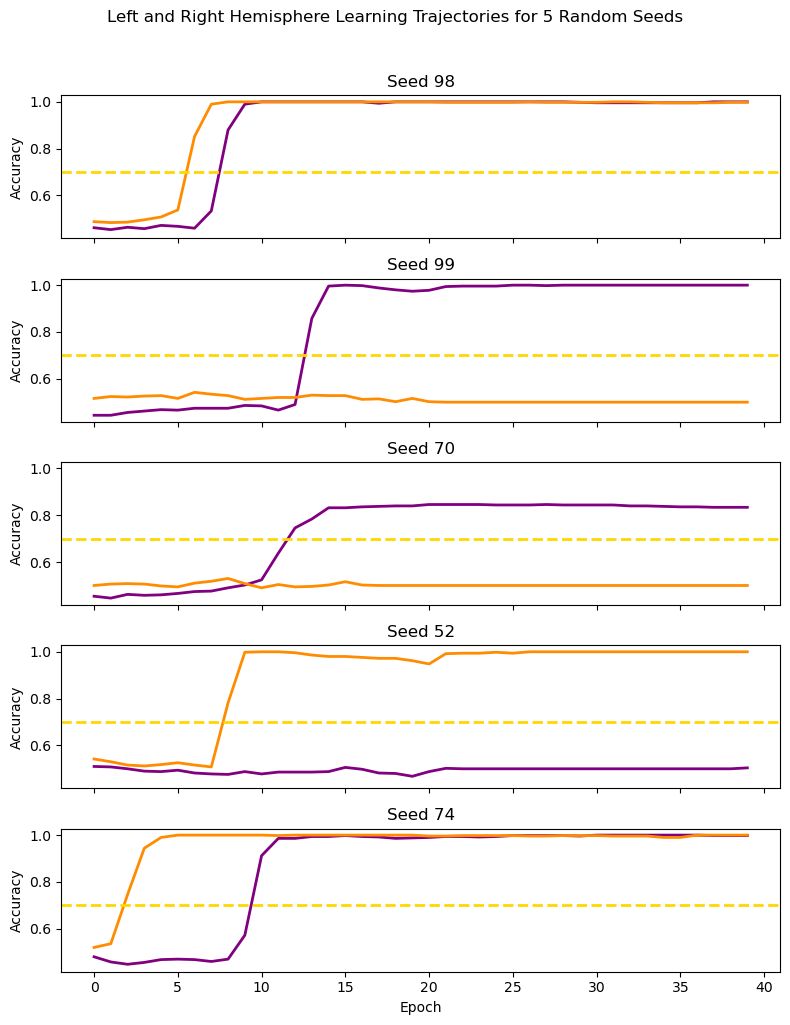

In [132]:
# Plot readout accuracies for right and left  over learning to view heterogeneity

right_lr = np.load('test/figs/lr/all_learning_right.npy')
left_lr = np.load('test/figs/lr/all_learning_left.npy')

import random

# Pick 5 random seeds (indices)
num_seeds = right_lr.shape[0]
random_seeds = np.random.choice(num_seeds, size=5, replace=False)

fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True, sharey=True)

epochs = np.arange(right_lr.shape[1])

for idx, seed in enumerate(random_seeds):
    axs[idx].plot(epochs, right_lr[seed], color='purple', linewidth=2, label='Right Hemi')
    axs[idx].plot(epochs, left_lr[seed], color='darkorange', linewidth=2, label='Left Hemi')
    axs[idx].axhline(0.7, color='gold', linestyle='--', linewidth=2)
    axs[idx].set_ylabel('Accuracy')
    axs[idx].set_title(f'Seed {seed}')
    # axs[idx].legend(loc='lower right')

axs[-1].set_xlabel('Epoch')
plt.suptitle('Left and Right Hemisphere Learning Trajectories for 5 Random Seeds', y=1.02)
plt.tight_layout()
plt.savefig('figs/learning_trajectories_5_random_seeds_1.pdf')
plt.show()




# # Compute the difference between left and right accuracies for each seed and epoch
# diff_lr = abs(left_lr - right_lr ) # shape: (num_seeds, num_epochs)

# fig, ax = plt.subplots(figsize=(8, 4))

# # Plot each seed's difference trajectory as a thin line
# for i in range(diff_lr.shape[0]):
#     ax.plot(epochs, diff_lr[i], color='gray', alpha=0.3, linewidth=1)

# # Plot the mean difference as a thick line
# mean_diff = np.mean(diff_lr, axis=0)
# ax.plot(epochs, mean_diff, color='black', linewidth=3, label='Mean (Left - Right)')

# ax.axhline(0, color='k', linestyle='--', linewidth=1)
# ax.set_xlabel('Epoch')
# ax.set_ylabel('Left - Right Accuracy')
# ax.set_title('Difference in Accuracy (Left - Right) Across Seeds')
# # ax.legend()

# plt.tight_layout()
# plt.savefig('figs/learning_trajectories_diff_left_right.pdf')
# plt.show()

# # Compute the epoch where left and right hemispheres reach 70% accuracy for each seed
# # If a seed never reaches 0.7, assign epoch as the last epoch (i.e., len(epochs)-1)

# left_70_epoch = []
# right_70_epoch = []

# for i in range(left_lr.shape[0]):
#     left_above = np.where(left_lr[i] >= 0.7)[0]
#     right_above = np.where(right_lr[i] >= 0.7)[0]
#     if len(left_above) == 0:
#         left_70_epoch.append(len(epochs)-1)
#     else:
#         left_70_epoch.append(left_above[0])
#     if len(right_above) == 0:
#         right_70_epoch.append(len(epochs)-1)
#     else:
#         right_70_epoch.append(right_above[0])

# left_70_epoch = np.array(left_70_epoch)
# right_70_epoch = np.array(right_70_epoch)

# # Compute the absolute difference in epochs for each seed
# epoch_diff = np.abs(left_70_epoch - right_70_epoch)

# # Plot: histogram of absolute epoch differences
# fig, ax = plt.subplots(figsize=(8, 6))

# # Plot histogram
# n, bins, patches = ax.hist(epoch_diff, #bins=np.arange(epoch_diff.min(), epoch_diff.max()+2)-0.5, 
#                            color='lightgrey', alpha=0.7, edgecolor='black', rwidth=0.9)

# # Annotate mean value with a vertical line
# mean_diff = np.mean(epoch_diff)
# ax.axvline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_diff:.2f}')

# # Optionally annotate the mean value
# ax.text(mean_diff, ax.get_ylim()[1]*0.95, f'{mean_diff:.2f}', color='red', ha='center', va='top', fontsize=12, fontweight='bold')

# ax.set_xlabel('Absolute Epoch Difference\n|Epoch$_{Left,70\%}$ - Epoch$_{Right,70\%}$|')
# ax.set_ylabel('Number of Seeds')
# ax.set_title('Distribution of Absolute Difference in 70% Accuracy Epoch (Left vs Right)')
# ax.legend()
# plt.tight_layout()
# plt.savefig('figs/epoch_diff_70pct_left_right_hist_abs.pdf')
# plt.show()


# # Compute the absolute difference in epochs for each seed
# epoch_diff = left_70_epoch - right_70_epoch

# # Plot: histogram of absolute epoch differences
# fig, ax = plt.subplots(figsize=(8, 6))

# # Plot histogram
# n, bins, patches = ax.hist(epoch_diff, #bins=np.arange(epoch_diff.min(), epoch_diff.max()+2)-0.5, 
#                            color='lightgrey', alpha=0.7, edgecolor='black', rwidth=0.9)

# # Annotate mean value with a vertical line
# mean_diff = np.mean(epoch_diff)
# ax.axvline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_diff:.2f}')

# # Optionally annotate the mean value
# ax.text(mean_diff, ax.get_ylim()[1]*0.95, f'{mean_diff:.2f}', color='red', ha='center', va='top', fontsize=12, fontweight='bold')

# ax.set_xlabel('Absolute Epoch Difference\n|Epoch$_{Left,70\%}$ - Epoch$_{Right,70\%}$|')
# ax.set_ylabel('Number of Seeds')
# ax.set_title('Distribution of Absolute Difference in 70% Accuracy Epoch (Left vs Right)')
# ax.legend()
# plt.tight_layout()
# plt.savefig('figs/epoch_diff_70pct_left_right_hist.pdf')
# plt.show()








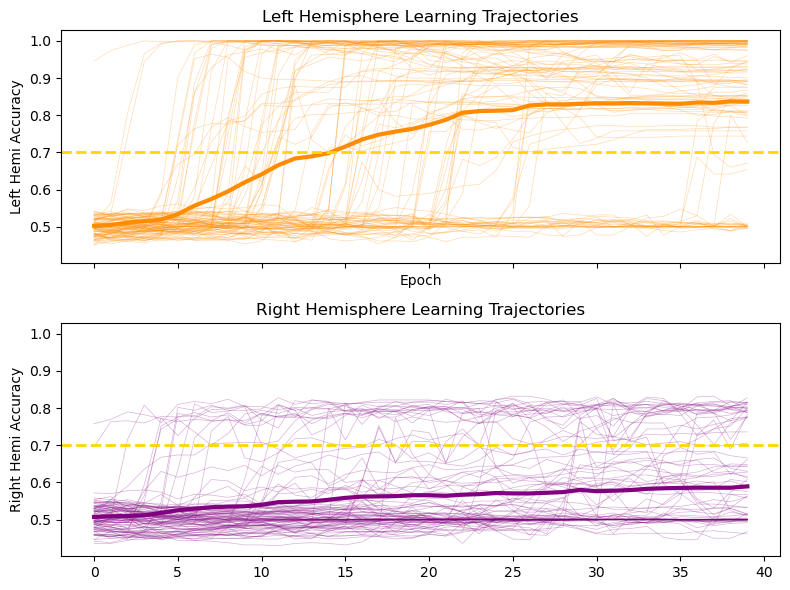

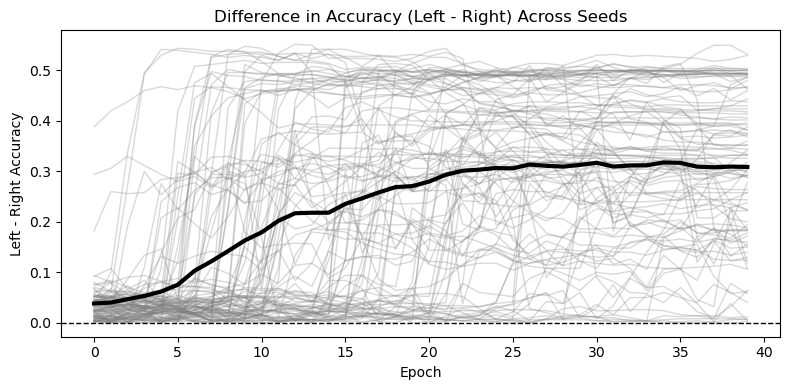

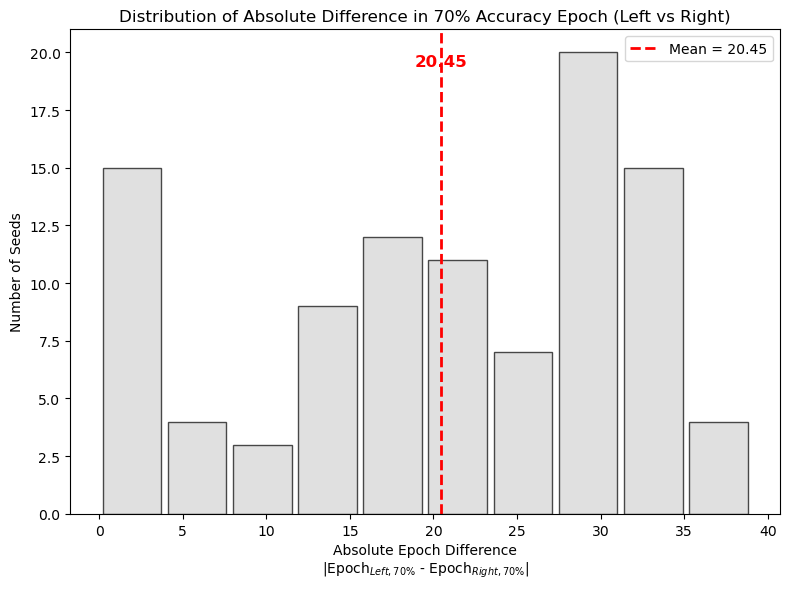

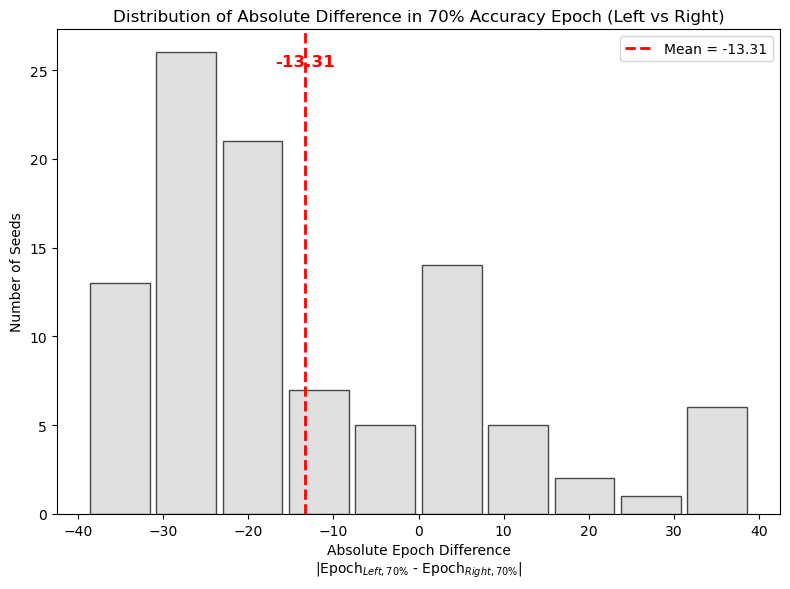

In [130]:
# Plot readout accuracies for right and left  over learning to view heterogeneity

right_lr = np.load('test/figs/lr/all_learning_right_L1_R0.2.npy')
left_lr = np.load('test/figs/lr/all_learning_left_L1_R0.2.npy')

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)

epochs = np.arange(right_lr.shape[1])

# Plot right hemisphere learning trajectories (top)
for i in range(right_lr.shape[0]):
    axs[1].plot(epochs, right_lr[i], color='purple', alpha=0.3, linewidth=0.5)
axs[1].plot(epochs, np.mean(right_lr, axis=0), color='purple', linewidth=3, label='Mean Right Hemi')
axs[1].set_ylabel('Right Hemi Accuracy')
axs[1].set_title('Right Hemisphere Learning Trajectories')
axs[1].axhline(0.7, color='gold', linestyle='--', linewidth=2)
# axs[0].legend()

# Plot left hemisphere learning trajectories (bottom)
for i in range(left_lr.shape[0]):
    axs[0].plot(epochs, left_lr[i], color='darkorange', alpha=0.3, linewidth=0.5)
axs[0].plot(epochs, np.mean(left_lr, axis=0), color='darkorange', linewidth=3, label='Mean Left Hemi')
axs[0].set_ylabel('Left Hemi Accuracy')
axs[0].set_title('Left Hemisphere Learning Trajectories')
axs[0].set_xlabel('Epoch')
axs[0].axhline(0.7, color='gold', linestyle='--', linewidth=2)

# axs[1].legend()

plt.tight_layout()
plt.savefig('figs/learning_trajectories_left_dominant.pdf')
plt.show()




# Compute the difference between left and right accuracies for each seed and epoch
diff_lr = abs(left_lr - right_lr ) # shape: (num_seeds, num_epochs)

fig, ax = plt.subplots(figsize=(8, 4))

# Plot each seed's difference trajectory as a thin line
for i in range(diff_lr.shape[0]):
    ax.plot(epochs, diff_lr[i], color='gray', alpha=0.3, linewidth=1)

# Plot the mean difference as a thick line
mean_diff = np.mean(diff_lr, axis=0)
ax.plot(epochs, mean_diff, color='black', linewidth=3, label='Mean (Left - Right)')

ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Left - Right Accuracy')
ax.set_title('Difference in Accuracy (Left - Right) Across Seeds')
# ax.legend()

plt.tight_layout()
# plt.savefig('figs/learning_trajectories_diff_left_right.pdf')
plt.show()

# Compute the epoch where left and right hemispheres reach 70% accuracy for each seed
# If a seed never reaches 0.7, assign epoch as the last epoch (i.e., len(epochs)-1)

left_70_epoch = []
right_70_epoch = []

for i in range(left_lr.shape[0]):
    left_above = np.where(left_lr[i] >= 0.7)[0]
    right_above = np.where(right_lr[i] >= 0.7)[0]
    if len(left_above) == 0:
        left_70_epoch.append(len(epochs)-1)
    else:
        left_70_epoch.append(left_above[0])
    if len(right_above) == 0:
        right_70_epoch.append(len(epochs)-1)
    else:
        right_70_epoch.append(right_above[0])

left_70_epoch = np.array(left_70_epoch)
right_70_epoch = np.array(right_70_epoch)

# Compute the absolute difference in epochs for each seed
epoch_diff = np.abs(left_70_epoch - right_70_epoch)

# Plot: histogram of absolute epoch differences
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram
n, bins, patches = ax.hist(epoch_diff, #bins=np.arange(epoch_diff.min(), epoch_diff.max()+2)-0.5, 
                           color='lightgrey', alpha=0.7, edgecolor='black', rwidth=0.9)

# Annotate mean value with a vertical line
mean_diff = np.mean(epoch_diff)
ax.axvline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_diff:.2f}')

# Optionally annotate the mean value
ax.text(mean_diff, ax.get_ylim()[1]*0.95, f'{mean_diff:.2f}', color='red', ha='center', va='top', fontsize=12, fontweight='bold')

ax.set_xlabel('Absolute Epoch Difference\n|Epoch$_{Left,70\%}$ - Epoch$_{Right,70\%}$|')
ax.set_ylabel('Number of Seeds')
ax.set_title('Distribution of Absolute Difference in 70% Accuracy Epoch (Left vs Right)')
ax.legend()
plt.tight_layout()
# plt.savefig('figs/epoch_diff_70pct_left_right_hist_abs.pdf')
plt.show()


# Compute the absolute difference in epochs for each seed
epoch_diff = left_70_epoch - right_70_epoch

# Plot: histogram of absolute epoch differences
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram
n, bins, patches = ax.hist(epoch_diff, #bins=np.arange(epoch_diff.min(), epoch_diff.max()+2)-0.5, 
                           color='lightgrey', alpha=0.7, edgecolor='black', rwidth=0.9)

# Annotate mean value with a vertical line
mean_diff = np.mean(epoch_diff)
ax.axvline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_diff:.2f}')

# Optionally annotate the mean value
ax.text(mean_diff, ax.get_ylim()[1]*0.95, f'{mean_diff:.2f}', color='red', ha='center', va='top', fontsize=12, fontweight='bold')

ax.set_xlabel('Absolute Epoch Difference\n|Epoch$_{Left,70\%}$ - Epoch$_{Right,70\%}$|')
ax.set_ylabel('Number of Seeds')
ax.set_title('Distribution of Absolute Difference in 70% Accuracy Epoch (Left vs Right)')
ax.legend()
plt.tight_layout()
# plt.savefig('figs/epoch_diff_70pct_left_right_hist.pdf')
plt.show()








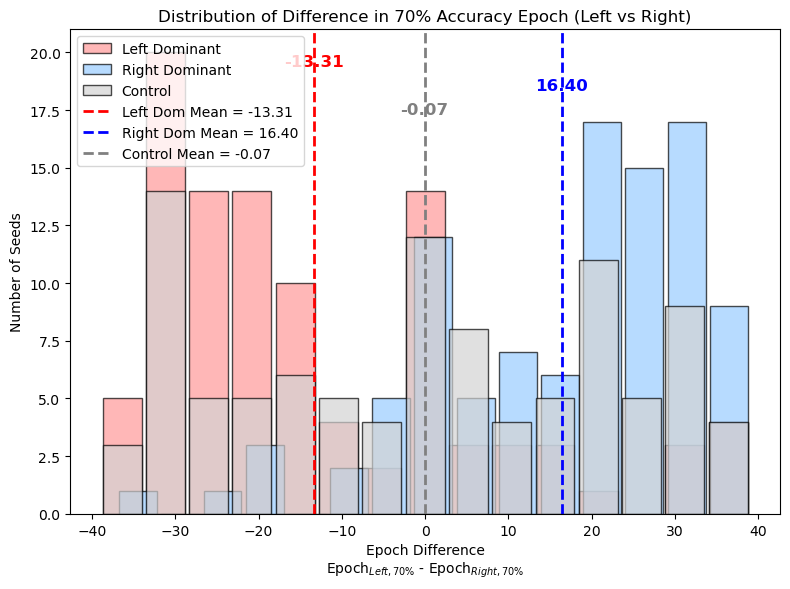

In [126]:
left_domright_lr = np.load('test/figs/lr/all_learning_right_L1_R0.2.npy')
left_domleft_lr = np.load('test/figs/lr/all_learning_left_L1_R0.2.npy')

right_domright_lr = np.load('test/figs/lr/all_learning_right_L0.2_R1.npy')
right_domleft_lr = np.load('test/figs/lr/all_learning_left_L0.2_R1.npy')

ctl_right_lr = np.load('test/figs/lr/all_learning_right.npy')
ctl_left_lr = np.load('test/figs/lr/all_learning_left.npy')






# Helper function to compute the epoch at which accuracy reaches 70%
def compute_70_epoch(acc_array):
    epochs_70 = []
    for i in range(acc_array.shape[0]):
        above = np.where(acc_array[i] >= 0.7)[0]
        if len(above) == 0:
            epochs_70.append(acc_array.shape[1] - 1)
        else:
            epochs_70.append(above[0])
    return np.array(epochs_70)

# Compute 70% epochs for all three conditions
# Left dominant
ld_left_70 = compute_70_epoch(left_domleft_lr)
ld_right_70 = compute_70_epoch(left_domright_lr)
ld_diff = ld_left_70 - ld_right_70

# Right dominant
rd_left_70 = compute_70_epoch(right_domleft_lr)
rd_right_70 = compute_70_epoch(right_domright_lr)
rd_diff = rd_left_70 - rd_right_70

# Control
ctl_left_70 = compute_70_epoch(ctl_left_lr)
ctl_right_70 = compute_70_epoch(ctl_right_lr)
ctl_diff = ctl_left_70 - ctl_right_70

# Plot histogram for all three conditions
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(
    min(ld_diff.min(), rd_diff.min(), ctl_diff.min()) - 0.5,
    max(ld_diff.max(), rd_diff.max(), ctl_diff.max()) + 1.5
) - 0.5

# n_ld, _, _ = ax.hist(ld_diff, bins=bins, color='#ff9999', alpha=0.7, edgecolor='black', rwidth=0.9, label='Left Dominant')
# n_rd, _, _ = ax.hist(rd_diff, bins=bins, color='#99ccff', alpha=0.7, edgecolor='black', rwidth=0.9, label='Right Dominant')
# n_ctl, _, _ = ax.hist(ctl_diff, bins=bins, color='lightgrey', alpha=0.7, edgecolor='black', rwidth=0.9, label='Control')


n_ld, _, _ = ax.hist(ld_diff, bins=15, color='#ff9999', alpha=0.7, edgecolor='black', rwidth=0.9, label='Left Dominant')
n_rd, _, _ = ax.hist(rd_diff, bins=15, color='#99ccff', alpha=0.7, edgecolor='black', rwidth=0.9, label='Right Dominant')
n_ctl, _, _ = ax.hist(ctl_diff, bins=15, color='lightgrey', alpha=0.7, edgecolor='black', rwidth=0.9, label='Control')


# Annotate mean values with vertical lines
mean_ld = np.mean(ld_diff)
mean_rd = np.mean(rd_diff)
mean_ctl = np.mean(ctl_diff)

ax.axvline(mean_ld, color='red', linestyle='--', linewidth=2, label=f'Left Dom Mean = {mean_ld:.2f}')
ax.axvline(mean_rd, color='blue', linestyle='--', linewidth=2, label=f'Right Dom Mean = {mean_rd:.2f}')
ax.axvline(mean_ctl, color='grey', linestyle='--', linewidth=2, label=f'Control Mean = {mean_ctl:.2f}')

# Optionally annotate the mean values
ax.text(mean_ld, ax.get_ylim()[1]*0.95, f'{mean_ld:.2f}', color='red', ha='center', va='top', fontsize=12, fontweight='bold')
ax.text(mean_rd, ax.get_ylim()[1]*0.90, f'{mean_rd:.2f}', color='blue', ha='center', va='top', fontsize=12, fontweight='bold')
ax.text(mean_ctl, ax.get_ylim()[1]*0.85, f'{mean_ctl:.2f}', color='grey', ha='center', va='top', fontsize=12, fontweight='bold')

ax.set_xlabel('Epoch Difference\nEpoch$_{Left,70\%}$ - Epoch$_{Right,70\%}$')
ax.set_ylabel('Number of Seeds')
ax.set_title('Distribution of Difference in 70% Accuracy Epoch (Left vs Right)')
ax.legend()
plt.tight_layout()
plt.savefig('figs/epoch_diff_70pct_left_right_hist_allconds.pdf')
plt.show()


